## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
C:\Users\User\.conda\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\.conda\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\.conda\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\.conda\envs\tf1-gpu\lib\site-packages\t

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 0.01      #[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.1, 0.3, 0.5, 0.7, 0.95]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mt in MOMENTUM:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    #print("Experiment with LR = %.6f" % (LEARNING_RATE))
    print("Experiment with MOMENTUM = %.3f" % (mt))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=mt)
    
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-mt-%s" % str(mt)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with MOMENTUM = 0.100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable params: 0
________________

50000/50000 [==============================] - 4s 72us/step - loss: 1.1887 - accuracy: 0.5809 - val_loss: 1.6783 - val_accuracy: 0.4299
Epoch 49/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.1824 - accuracy: 0.5841 - val_loss: 1.4081 - val_accuracy: 0.4946
Epoch 50/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1726 - accuracy: 0.5874 - val_loss: 1.5070 - val_accuracy: 0.4736
Experiment with MOMENTUM = 0.300
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________________

50000/50000 [==============================] - 3s 60us/step - loss: 1.1426 - accuracy: 0.5964 - val_loss: 1.5473 - val_accuracy: 0.4760
Epoch 46/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.1275 - accuracy: 0.6003 - val_loss: 1.4637 - val_accuracy: 0.5024
Epoch 47/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.1208 - accuracy: 0.6041 - val_loss: 1.4132 - val_accuracy: 0.5059
Epoch 48/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.1131 - accuracy: 0.6039 - val_loss: 1.4252 - val_accuracy: 0.4956
Epoch 49/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.1082 - accuracy: 0.6070 - val_loss: 1.3307 - val_accuracy: 0.5313
Epoch 50/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.0980 - accuracy: 0.6123 - val_loss: 1.3907 - val_accuracy: 0.5131
Experiment with MOMENTUM = 0.500
Model: "model_1"
_________________________________________________________________
Layer (t

50000/50000 [==============================] - 3s 60us/step - loss: 1.0730 - accuracy: 0.6210 - val_loss: 1.4730 - val_accuracy: 0.4911
Epoch 43/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.0596 - accuracy: 0.6259 - val_loss: 1.4170 - val_accuracy: 0.5060
Epoch 44/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.0475 - accuracy: 0.6304 - val_loss: 1.4627 - val_accuracy: 0.4992
Epoch 45/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.0351 - accuracy: 0.6352 - val_loss: 1.4122 - val_accuracy: 0.5087
Epoch 46/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.0316 - accuracy: 0.6383 - val_loss: 1.5801 - val_accuracy: 0.4729
Epoch 47/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.0210 - accuracy: 0.6398 - val_loss: 1.4038 - val_accuracy: 0.5138
Epoch 48/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.0018 - accuracy: 0.6490 - val_loss: 1.5313

50000/50000 [==============================] - 3s 51us/step - loss: 0.9314 - accuracy: 0.6703 - val_loss: 1.6483 - val_accuracy: 0.4721
Epoch 40/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.9283 - accuracy: 0.6729 - val_loss: 1.6931 - val_accuracy: 0.4672
Epoch 41/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.9038 - accuracy: 0.6814 - val_loss: 1.4676 - val_accuracy: 0.5107
Epoch 42/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.8875 - accuracy: 0.6852 - val_loss: 1.6112 - val_accuracy: 0.4872
Epoch 43/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8729 - accuracy: 0.6902 - val_loss: 1.4351 - val_accuracy: 0.5153
Epoch 44/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.8523 - accuracy: 0.6974 - val_loss: 1.5333 - val_accuracy: 0.5100
Epoch 45/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.8438 - accuracy: 0.6995 - val_loss: 1.5709

50000/50000 [==============================] - 3s 61us/step - loss: 0.6305 - accuracy: 0.7710 - val_loss: 1.7706 - val_accuracy: 0.5205
Epoch 37/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.6110 - accuracy: 0.7791 - val_loss: 1.8018 - val_accuracy: 0.5167
Epoch 38/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.5933 - accuracy: 0.7844 - val_loss: 1.7668 - val_accuracy: 0.5279
Epoch 39/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5836 - accuracy: 0.7881 - val_loss: 1.8022 - val_accuracy: 0.5219
Epoch 40/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.5728 - accuracy: 0.7927 - val_loss: 1.7946 - val_accuracy: 0.5163
Epoch 41/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.5471 - accuracy: 0.8012 - val_loss: 1.9045 - val_accuracy: 0.5197
Epoch 42/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.5244 - accuracy: 0.8125 - val_loss: 1.8842

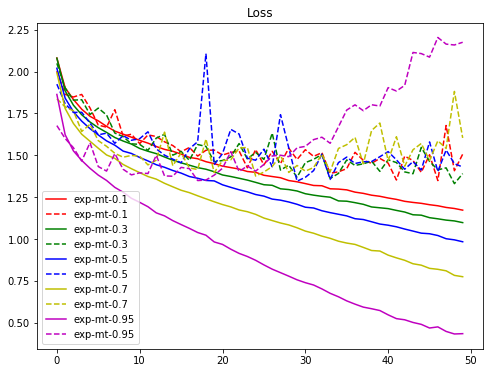

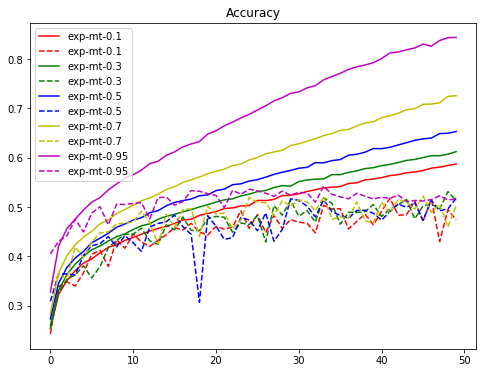

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()